## Proyecto: Turismo de los Alpes  - Grupo 34
Felipe Nuñez - 202021673
<br>
Jeronimo Vargas Rendon - 202113305
<br>
Juan Manuel Pérez - 202021827

In [2]:
# Importar librerias
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import re
import spacy
import stanza
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Jeronimo
[nltk_data]     Vargas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jeronimo
[nltk_data]     Vargas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Cargar Datos

In [3]:
# Carga de datos
df = pd.read_csv('tipo1_entrenamiento_estudiantes.csv')

## 1. Entendimiento de los datos

In [4]:
# Visualización de los primeros registros
print(df.head())

# Total de registros
print("Total de registros:", df.shape[0])

                                              Review  Class
0  Nos alojamos en una casa alquilada en la ciuda...      4
1  La comida está bien, pero nada especial. Yo te...      3
2  En mi opinión, no es una como muchos usuarios ...      3
3  esta curiosa forma que asemeja una silla de mo...      4
4  Lo mejor era la limonada. Me gusto la comida d...      2
Total de registros: 7875


De entrada tenemos que se encuentran 7875 observaciones, y hay dos variables. La primera es la variable Review que es una cadena de cáracteres y hace referencia a el comentario de los viajeros. La segunda variable es Class, esta variable es nuestra variable objetivo pues esta representa la satisfaccion del viajero.

Analisis de Dimension de calidad de datos:
### - Unicidad:

In [5]:
#Contar duplicados
print("Duplicados:" , df.duplicated().sum())

Duplicados: 71


Hay 71 observaciones duplicadas, es necesario eliminar las filas repetidas y dejar solo una observación. Ya que dejarlas incrementaria los efectos de algunas palabras dada su repetición en el modelo.

In [6]:
df = df.drop_duplicates()
print(df.duplicated().sum())

0


### - Completitud:

In [7]:
# Verificación de valores faltantes
print(df.isnull().sum())

Review    0
Class     0
dtype: int64


No hay valores nulos los datos estan completos. Se cumple completitud.

### - Validez:

In [8]:
df["Class"].describe()

count    7804.000000
mean        3.500128
std         1.324219
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: Class, dtype: float64

In [9]:
df.dtypes

Review    object
Class      int64
dtype: object

Los datos cumplen con el formato esperado. La varible objetivo cumple con el rango esperado entre 1 y 5. Pues para Review se puede observar que es de tipo object el cual hace referencia a una cadena de textos.

### - Consistencia:
Si cumple

## 2. Preparación de los datos

### Limpieza de los datos:

Para este proceso de limpieza de datos es necesario hacer una limpieza de las palabras que no agregan valor. Para esto se definio la función remove_ noise que se encarga de eliminar ciertos tipos de ruido o elementos no deseados del texto antes de continuar con el proceso de limpieza.

1. re.sub(r'<.*?>', '', text): Utiliza expresiones regulares para eliminar todas las etiquetas HTML presentes en el texto. Esto es importante si estás trabajando con texto extraído de páginas web o documentos HTML, ya que las etiquetas HTML no proporcionan información útil para el análisis de texto y pueden interferir con los procesos de limpieza y análisis posteriores.

2. re.sub(r'[0-9]+', '', text): Utiliza expresiones regulares para eliminar todos los números del texto. Al observar algunas de los Review muchos de los números que se encontraban, hacen referencia a fechas o horas. Por esta razón, consideramos que los numeros no agregaban valor a estos comentarios y se eliminaron los números de los comentarios.

3. re.sub(r'[^a-záéíóúñA-ZÁÉÍÓÚÑ\s]', '', text): Utiliza expresiones regulares para eliminar todos los caracteres especiales excepto los espacios en blanco y los caracteres alfabéticos (incluyendo letras con tilde y la ñ). Esto es útil para eliminar signos de puntuación, símbolos y otros caracteres que no aportan significado semántico al texto. Sin embargo, conserva los espacios en blanco para preservar la estructura del texto.

4. re.sub(r'\s+', ' ', text): Utiliza expresiones regulares para reemplazar múltiples espacios en blanco consecutivos por un solo espacio en blanco. Esto ayuda a normalizar la cantidad de espacios en el texto, lo que facilita el procesamiento posterior.

5. text = text.lower(): Convierte todo el texto a minúsculas. Esto es importante para garantizar la consistencia en el texto y evitar problemas de diferenciación entre mayúsculas y minúsculas durante el análisis.

La otra función que se definio es clean_text, que se encarga de las "stopwords". Las "stopwords" son palabras que se filtran del texto durante el análisis de procesamiento del lenguaje natural (NLP) porque no aportan un significado contextual importante para el análisis. La función especificamente tokeniza el texto en palabras y luego filtra aquellas que no son stopwords ni caracteres alfabéticos, reconstruyendo el texto sin las stopwords.

In [10]:
def remove_noise(text):
    text = re.sub(r'<.*?>', '', text)  # Eliminar HTML tags
    text = re.sub(r'[0-9]+', '', text) # Elimnar numeros
    text = re.sub(r'[^a-záéíóúñA-ZÁÉÍÓÚÑ\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

# Definición de las stopwords en español
stop_words = set(stopwords.words('spanish'))

def clean_text(text):
    words = word_tokenize(text)  # Tokenizar el texto en palabras
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    # Reconstrucción del texto
    return " ".join(filtered_words)

def preprocessing(text):
    cleaned_text = remove_noise(text)  # Remover ruido del texto
    cleaned_words = clean_text(cleaned_text)  # Limpiar el texto
    return cleaned_words

### Tokenización:

In [11]:
df['palabras']=df['Review'].apply(preprocessing)

df.head()

,Review,Class,palabras
0,Nos alojamos en una casa alquilada en la ciuda...,4,alojamos casa alquilada ciudad amurallada pare...
1,"La comida está bien, pero nada especial. Yo te...",3,comida bien especial mejor comida mexcan unido...
2,"En mi opinión, no es una como muchos usuarios ...",3,opinión usuarios reclaman gran paladar parece ...
3,esta curiosa forma que asemeja una silla de mo...,4,curiosa forma asemeja silla montar ahi nombre ...
4,Lo mejor era la limonada. Me gusto la comida d...,2,mejor limonada gusto comida mundo sosa frío


En la tokenización se observa que se aplica la funcion de preprocesamiento que se explico anteriormente. Como resultado de esta tokenización preprocesada, se obtienen únicamente las palabras que cuentan con un sentido semántico. Esto significa que las palabras resultantes después del preprocesamiento son aquellas que tienen relevancia para el análisis de texto.

### Normalización:

El objetivo principal de la lematización es reducir las palabras a su forma canónica para facilitar el análisis semántico. Para esto se utilizo la libreria de Stanza desarrollada por el grupo de investigación de la Universidad de Stanford. En la siguiente función, Stanza realiza la lematización de las palabras en español. Después de procesar el texto, Stanza identifica y reemplaza cada palabra con su lema correspondiente. 

In [12]:
stanza.download('es')

nlp = stanza.Pipeline(lang='es', processors='tokenize,lemma')

def process_text_stanza(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([word.lemma for sent in doc.sentences for word in sent.words])
    return lemmatized_text

df['palabras'] = df['palabras'].apply(process_text_stanza)

df.head()

2024-04-17 21:44:06 INFO: Downloaded file to C:\Users\Jeronimo Vargas\stanza_resources\resources.json
2024-04-17 21:44:06 INFO: Downloading default packages for language: es (Spanish) ...


2024-04-17 21:48:49 INFO: Downloaded file to C:\Users\Jeronimo Vargas\stanza_resources\es\default.zip
2024-04-17 21:48:58 INFO: Finished downloading models and saved to C:\Users\Jeronimo Vargas\stanza_resources
2024-04-17 21:48:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-17 21:48:58 INFO: Downloaded file to C:\Users\Jeronimo Vargas\stanza_resources\resources.json
2024-04-17 21:48:58 WARNING: Language es package default expects mwt, which has been added
2024-04-17 21:48:59 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| lemma     | ancora_nocharlm |

2024-04-17 21:48:59 INFO: Using device: cpu
2024-04-17 21:48:59 INFO: Loading: tokenize
2024-04-17 21:49:01 INFO: Loading: mwt
2024-04-17 21:49:01 INFO: Loading: lemma
2024-04-17 21:49:01 INFO: Done loading processors!


,Review,Class,palabras
0,Nos alojamos en una casa alquilada en la ciuda...,4,alojamo casa alquilada ciudad amurallada parec...
1,"La comida está bien, pero nada especial. Yo te...",3,comida bien especial mejor comida mexcan unido...
2,"En mi opinión, no es una como muchos usuarios ...",3,opinión usuario reclamar gran paladar parecer ...
3,esta curiosa forma que asemeja una silla de mo...,4,curioso forma asemejar silla montar ahi nombre...
4,Lo mejor era la limonada. Me gusto la comida d...,2,mejor limonada gusto comida mundo sosa frío


### Transformación:
Para poder realizar un modelo analisis de textos es necesario representar el texto númericamente para poder aplicar los algoritmos de aprendizaje automatico. Hay diferentes transformaciones posibles, se probaron 3: 
- Term Frequency Inverse Document Frequency
- Count vectorizer
- Count Vectorizer Dummy

1. Term Frequency Inverse Document Frequency:
Es una medida estadistica que evalua la importancia de una palabra en el Review. Creando una matriz por cada Review y cada termino.

In [13]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['palabras']).toarray()

2. Count Vectorizer:
Cuenta la frecuencia de ocurrencia de cada palabra en cada Review. Por esta razon construye una matriz de ocurrencias.

In [14]:
count = CountVectorizer()
X_count = count.fit_transform(df['palabras'])
print(X_count.shape)
X_count.toarray()[0]

(7804, 21183)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

3. Count Vectorizer Binario:
Cuenta las ocurrencias de palabras, simplemente marca la presencia o ausencia de una palabra en un Review utilizando valores binarios (1 para presencia, 0 para ausencia).

In [15]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(df['palabras'])
print(X_dummy.shape)
X_dummy.toarray()[0]

(7804, 21183)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## 3. Modelo

Dado que se realizaron 3 transformaciones se corrieron tres modelos con los algoritmos seleccionados para compararlos basandonos en sus metricas y escoger el modelo que mejor se adapte a el contexto. Por esta razon, se definieron 3 sets de datos dependiendo de la transformacion en el que se realizo un 70% de entrenamiento y un 30% de los datos para la prueba.

In [16]:
y=df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_count, y, test_size=0.3, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_dummy, y, test_size=0.3, random_state=42)

1. Term Frequency Inverse Document Frequency:

In [17]:
# Regression logistica

modelLR = LogisticRegression()
modelLR.fit(X_train, y_train)
y_pred = modelLR.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


              precision    recall  f1-score   support

           1       0.54      0.37      0.44       246
           2       0.42      0.34      0.37       354
           3       0.38      0.37      0.38       463
           4       0.38      0.40      0.39       603
           5       0.58      0.69      0.63       676

    accuracy                           0.46      2342
   macro avg       0.46      0.43      0.44      2342
weighted avg       0.46      0.46      0.46      2342

Accuracy: 0.4645602049530316


El modelo realizado fue una regresión logistica para el set de datos de Term Frequency Inverse Document Frequency. La precisión global del modelo es del 46.46%, lo que significa que el modelo clasifica correctamente el 46.46% de las muestras del conjunto de prueba. El recall es de 0.46 y este indentifica todas las muestras positivas. El F1-Score fue de 0.46 y esta medida combina la precision y el recall, se espera que este valor sea lo más cercano a 1.


In [18]:
# Modelo multinomial Naive Bayes

modelNB = MultinomialNB()
modelNB.fit(X_train, y_train)
y_pred = modelNB.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           1       0.59      0.19      0.29       246
           2       0.42      0.39      0.40       354
           3       0.38      0.30      0.34       463
           4       0.40      0.39      0.39       603
           5       0.53      0.76      0.62       676

    accuracy                           0.46      2342
   macro avg       0.46      0.41      0.41      2342
weighted avg       0.45      0.46      0.44      2342

Accuracy: 0.45815542271562765


El modelo realizado fue un multinomial Naive Bayes para el set de datos de Term Frequency Inverse Document Frequency. La precisión global del modelo es del 45.82%, lo que significa que el modelo clasifica correctamente el 45.82% de las muestras del conjunto de prueba. El recall es de 0.46 y este indentifica todas las muestras positivas. El F1-Score fue de 0.44 y esta medida combina la precision y el recall, se espera que este valor sea lo más cercano a 1.

In [19]:
# Modelo Random Forest

modelRF = RandomForestClassifier()
modelRF.fit(X_train, y_train)
y_pred = modelRF.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           1       0.49      0.20      0.29       246
           2       0.39      0.40      0.40       354
           3       0.39      0.31      0.34       463
           4       0.38      0.36      0.37       603
           5       0.52      0.72      0.60       676

    accuracy                           0.44      2342
   macro avg       0.43      0.40      0.40      2342
weighted avg       0.43      0.44      0.43      2342

Accuracy: 0.44321093082835183


El modelo realizado fue un Random Forest para el set de datos de Term Frequency Inverse Document Frequency. La precisión global del modelo es del 45.42% el menor en los resultados del set. El recall es de 0.45 y este indentifica todas las muestras positivas. El F1-Score fue de 0.43 y esta medida combina la precision y el recall. En terminos generales este entre los primeros 3 modelos, este modelo es el que cuenta con peores resultados.

2. Count Vectorizer:

In [20]:
# Regression logistica

modelLR = LogisticRegression()
modelLR.fit(X_train2, y_train2)
y_pred = modelLR.predict(X_test2)
print(classification_report(y_test2, y_pred))
print(f"Accuracy: {accuracy_score(y_test2, y_pred)}")


              precision    recall  f1-score   support

           1       0.48      0.43      0.46       246
           2       0.40      0.30      0.34       354
           3       0.38      0.38      0.38       463
           4       0.39      0.40      0.40       603
           5       0.58      0.67      0.62       676

    accuracy                           0.46      2342
   macro avg       0.45      0.44      0.44      2342
weighted avg       0.46      0.46      0.46      2342

Accuracy: 0.4632792485055508


c:\Users\Jeronimo Vargas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El modelo realizado fue una regresión logistica para el set de datos de Count Vectorizer. La precisión global del modelo es del 46.32%, lo que significa que el modelo clasifica correctamente el 46.32% de las muestras del conjunto de prueba. El recall es de 0.46 y este indentifica todas las muestras positivas. El F1-Score fue de 0.46 y esta medida combina la precision y el recall, se espera que este valor sea lo más cercano a 1.

In [21]:
# Modelo multinomial Naive Bayes

modelNB = MultinomialNB()
modelNB.fit(X_train2, y_train2)
y_pred = modelNB.predict(X_test2)
print(classification_report(y_test2, y_pred))
print(f"Accuracy: {accuracy_score(y_test2, y_pred)}")

              precision    recall  f1-score   support

           1       0.59      0.20      0.29       246
           2       0.38      0.39      0.39       354
           3       0.37      0.32      0.35       463
           4       0.39      0.45      0.42       603
           5       0.61      0.71      0.65       676

    accuracy                           0.46      2342
   macro avg       0.47      0.41      0.42      2342
weighted avg       0.47      0.46      0.45      2342

Accuracy: 0.46498719043552517


El modelo realizado fue un multinomial Naive Bayes para el set de datos de Count Vectorizer. La precisión global del modelo es del 46.50%, lo que significa que el modelo clasifica correctamente el 46.50% de las muestras del conjunto de prueba. El recall es de 0.46 y este indentifica todas las muestras positivas. El F1-Score fue de 0.45 y esta medida combina la precision y el recall, se espera que este valor sea lo más cercano a 1.

In [22]:
# Modelo Random Forest

modelRF = RandomForestClassifier()
modelRF.fit(X_train2, y_train2)
y_pred = modelRF.predict(X_test2)
print(classification_report(y_test2, y_pred))
print(f"Accuracy: {accuracy_score(y_test2, y_pred)}")


              precision    recall  f1-score   support

           1       0.67      0.19      0.29       246
           2       0.43      0.32      0.37       354
           3       0.34      0.26      0.30       463
           4       0.36      0.32      0.34       603
           5       0.48      0.78      0.59       676

    accuracy                           0.43      2342
   macro avg       0.45      0.38      0.38      2342
weighted avg       0.43      0.43      0.40      2342

Accuracy: 0.4295473953885568


El modelo realizado fue un Random Forest para el set de datos de Count Vectorizer. La precisión global del modelo es del 43.33% el menor en los resultados del set. El recall es de 0.43 y este indentifica todas las muestras positivas. El F1-Score fue de 0.40 y esta medida combina la precision y el recall. En terminos generales este entre los primeros 3 modelos, este modelo es el que cuenta con peores resultados para su set de datos (Count Vectorize).

3. Count Vectorizer Binario:

In [23]:
# Regression logistica

modelLR = LogisticRegression()
modelLR.fit(X_train3, y_train3)
y_pred = modelLR.predict(X_test3)
print(classification_report(y_test3, y_pred))
print(f"Accuracy: {accuracy_score(y_test3, y_pred)}")


              precision    recall  f1-score   support

           1       0.48      0.42      0.45       246
           2       0.40      0.30      0.34       354
           3       0.39      0.38      0.38       463
           4       0.39      0.41      0.40       603
           5       0.58      0.66      0.62       676

    accuracy                           0.46      2342
   macro avg       0.45      0.43      0.44      2342
weighted avg       0.45      0.46      0.45      2342

Accuracy: 0.4594363791631085


El modelo realizado fue una regresión logistica para el set de datos de Count Vectorizer Binario. La precisión global del modelo es del 45.94%, lo que significa que el modelo clasifica correctamente el 45.94% de las muestras del conjunto de prueba. El recall es de 0.46 y este indentifica todas las muestras positivas. El F1-Score fue de 0.45 y esta medida combina la precision y el recall, se espera que este valor sea lo más cercano a 1.

In [24]:
# Modelo multinomial Naive Bayes

modelNB = MultinomialNB()
modelNB.fit(X_train3, y_train3)
y_pred = modelNB.predict(X_test3)
print(classification_report(y_test3, y_pred))
print(f"Accuracy: {accuracy_score(y_test3, y_pred)}")

              precision    recall  f1-score   support

           1       0.58      0.15      0.24       246
           2       0.39      0.40      0.40       354
           3       0.37      0.32      0.34       463
           4       0.39      0.46      0.42       603
           5       0.60      0.72      0.65       676

    accuracy                           0.46      2342
   macro avg       0.47      0.41      0.41      2342
weighted avg       0.47      0.46      0.45      2342

Accuracy: 0.4637062339880444


El modelo realizado fue un multinomial Naive Bayes para el set de datos de Count Vectorizer Binario. La precisión global del modelo es del 46.37%, lo que significa que el modelo clasifica correctamente el 46.37% de las muestras del conjunto de prueba. El recall es de 0.46 y este indentifica todas las muestras positivas. El F1-Score fue de 0.45 y esta medida combina la precision y el recall, se espera que este valor sea lo más cercano a 1.

In [25]:
# Modelo Random Forest

modelRF = RandomForestClassifier()
modelRF.fit(X_train3, y_train3)
y_pred = modelRF.predict(X_test3)
print(classification_report(y_test3, y_pred))
print(f"Accuracy: {accuracy_score(y_test3, y_pred)}")

              precision    recall  f1-score   support

           1       0.57      0.15      0.24       246
           2       0.39      0.32      0.36       354
           3       0.34      0.24      0.28       463
           4       0.36      0.33      0.35       603
           5       0.47      0.77      0.59       676

    accuracy                           0.42      2342
   macro avg       0.43      0.36      0.36      2342
weighted avg       0.42      0.42      0.39      2342

Accuracy: 0.4210076857386849


El modelo realizado fue un Random Forest para el set de datos de Count Vectorizer Binario. La precisión global del modelo es del 42.95% el menor en los resultados del set. El recall es de 0.43 y este indentifica todas las muestras positivas. El F1-Score fue de 0.40 y esta medida combina la precision y el recall. En terminos generales este entre los primeros 3 modelos, este modelo es el que cuenta con peores resultados para su set de datos (Count Vectorizer Binario).

## 4. Selección del modelo

Basado en las metricas anteriores el modelo que se considera mejor es:
Multinomial Naive Bayes utilizando la transformacion de Count Vectorizer debido a que obtuvo metricas superiores a las de los otros modelos


In [26]:
# Modelo multinomial Naive Bayes

modelNB = MultinomialNB()
modelNB.fit(X_train2, y_train2)
y_pred = modelNB.predict(X_test2)

# Palabras
feature_names = count.get_feature_names_out()

# Probabilidades de cada palabra
log_probabilities = modelNB.feature_log_prob_

# Transponer las probabilidades
log_probabilities_transposed = log_probabilities.T

# Crear el dataframe
word_prob_df = pd.DataFrame(log_probabilities_transposed, columns=modelNB.classes_, index=feature_names)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

word_prob_df.to_excel('word_probabilities.xlsx')

## 5. Resultados

Es importante que el algoritmo seleccionado brinda la probabilidad logaritmica de cada palabra en cada clase. Esto quiere decir que las palabras que más influyen en una clase son las que más cercanas a 0 sean. Dado el alto número de palabras en el modelo, se exportaron los resultados en un archivo xlsx y se creo una nueva columna para calcluar la diferencia absoluta entre la probabilidad de la clase 1 y la clase 5 y se ordeno de mayor a menor. De esta formta forma se podia saber cuales eran las palabras que mas influian entre los extremos de las categorias. Se obtuvo la siguiente tabla.

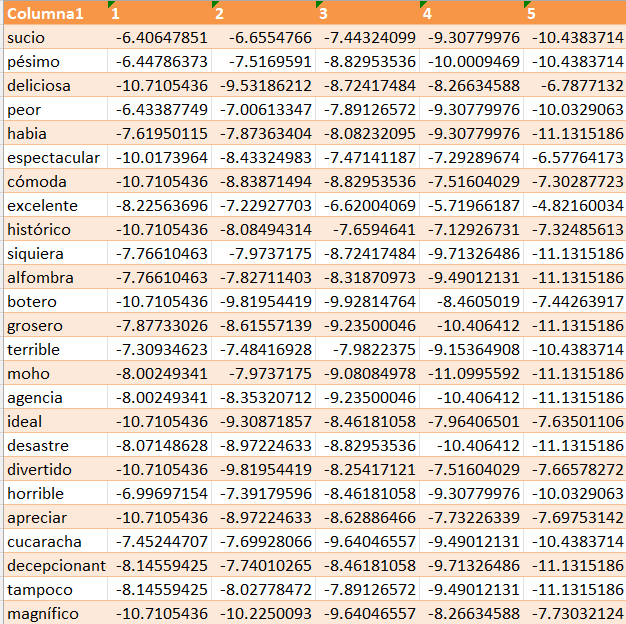

Entre los resultados resaltan algunas palabras como:
- sucio: Con una influencia mayor en la clase 1 que en la clase 5.
- cómoda: Con una influencia mayor en la clase 5 que en la clase 1.
- historico: Con una influencia mayor en la clase 5 que en la clase 1.
- alfombra: Con una influencia mayor en la clase 1 que en la clase 5.
- moho: Con una influencia mayor en la clase 1 que en la clase 5.
- jardin: Con una influencia mayor en la clase 5 que en la clase 1.
- cucaracha: Con una influencia mayor en la clase 1 que en la clase 5.

De esta forma se obtiene algunos diferenciadores entre las clases como lo puede ser la suciedad, que trae una conotacion negativa hacia los huespedes. La comodidad que es un aspecto importante en el buen servicio para los huespedes. El hecho que sea historico tiene influencia en los huespedes por lo que pueden buscar implementar o mantener este aspecto. El hecho de que no haya alfombras es importante en la percepcion de los huespedes. De igual forma que no haya moho o que no se encuentren cucarachas. El hecho de que exista un jardin es importante para los huespedes por lo que los hoteles deberian implementar estos espacios.

## 6. Predicciones Archivo de Prueba

In [27]:
# Predicciones con el modelo a los siguientes Datos usando el mejor modelo obtenido

df_pred = pd.read_csv('particion_prueba_estudiantes.csv')

df_p = df_pred.copy()

# Predecir con el modelo de Multinomial Naive Bayes
df_p['Palabras'] = df_p['Review'].apply(preprocessing)
df_p['Palabras'] = df_p['Palabras'].apply(process_text_stanza)
X_pred = count.transform(df_p['Palabras'])
y_pred = modelNB.predict(X_pred)
df_p['Class'] = y_pred

# Guardar predicciones
df_p['Class'] = y_pred
df_p.drop(columns=['Palabras'], inplace=True)

df_p.to_csv('predicciones_estudiantes.csv', index=False)
print(df_p.head())


                                              Review  Class
0  La primera noche nos encontramos en la habitac...      2
1  A una calle de catedral con platillos tradicio...      5
2  Porciones muy miserables\nAgua con sabor a clo...      3
3  Cartagena encanta. De todas las ciudades colon...      5
4  Ibamos con mucha ilusion de disfrutar el espec...      4


In [29]:
# Exportar modelo

import joblib

joblib.dump(modelNB, 'modelo_NB.pkl')

# Crear pipeline

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', count),
    ('model', modelNB),
    ('preprocessor', preprocessing),
    ('lemmatizer', process_text_stanza)
])

